# Metagenome analysis

## Set working directory

In [63]:
setwd('e:/permafrost')
wd_16s <- file.path(getwd(),"data/16S")
# if (!dir.exists(wd_16s)) {
#   dir.create(wd_16s)
# }
wd_fun <- file.path(getwd(),"data/metagenome")
save.dir <- file.path(getwd(),"result")
# if (!dir.exists(wd_fun)) {
#   dir.create(wd_fun)
# }

## Loading packages

In [64]:
ipak <- function(pkg){
  new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
  if (length(new.pkg)) 
    install.packages(new.pkg, dependencies = TRUE)
  sapply(pkg, require, character.only = TRUE)
}
pkgs <- c('phyloseq', 'picante', 'microbiome', 'readxl', 'tidyverse',
          'ggpubr', 'ggplot2')
suppressWarnings(ipak(pkgs))

phyloseq    picante microbiome     readxl  tidyverse     ggpubr    ggplot2 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

## Read input files

In [65]:
metadata <- read.delim(file.path(wd_16s, "./metadata_final.txt"), header = T, sep = "\t")
rownames(metadata) <- (metadata$sample_id)
ko_tpm_table <- read.delim(file.path(wd_fun, "./fun/eggnog.KEGG_ko.raw.tpm.txt"), 
                           header = T, row.names = 1, sep = "\t")
ko_count_table <- read.delim(file.path(wd_fun, "./fun/eggnog.KEGG_ko.raw.counts.txt"), 
                             header = T, row.names = 1, sep = "\t")
ko_tpm_table <- ko_tpm_table[, metadata$sample_id[metadata$sample_id %in% colnames(ko_tpm_table)]]
ko_count_table <- ko_count_table[, metadata$sample_id[metadata$sample_id %in% colnames(ko_count_table)]]

## functional analysis

### PERMANOVA test

In [54]:
suppressWarnings(library(vegan))
fun_dist <- as.matrix(vegdist(t(ko_tpm_table), "bray" ))
adonis2(fun_dist ~ Layer, data = metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer,2,0.1784994,0.2216569,8.970586,0.001
Residual,63,0.6267964,0.7783431,NA,NA
Total,65,0.8052958,1.0000000,NA,NA


In [3]:
library(pairwiseAdonis)
set.seed(123)
pairwise.adonis(fun_dist, metadata$Layer)

Loading required package: cluster



pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SUR vs SUB,1,0.2273391,31.042516,0.4249924,0.001,0.003,*
SUR vs PL,1,0.2316485,13.583606,0.2443815,0.001,0.003,*
SUB vs PL,1,0.1080141,5.861651,0.1224707,0.008,0.024,.


[1] 31.1 25.7

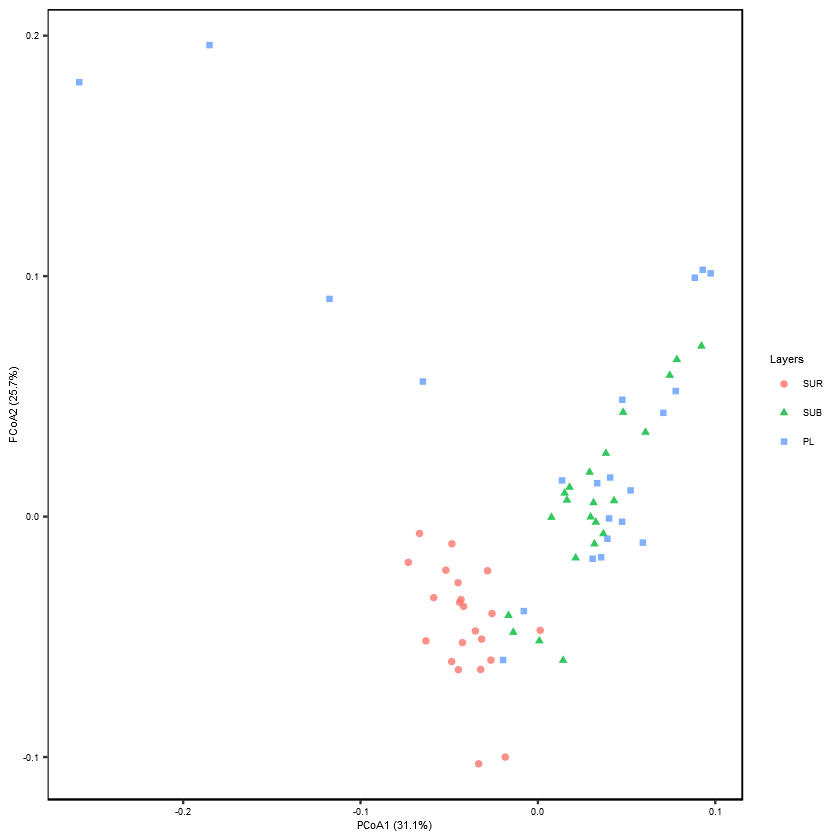

In [4]:
library(ggplot2)
### PCoA plot
ord.fun <-  cmdscale(fun_dist,  k = 2, eig = T, add = T)
round(ord.fun$eig*100/sum(ord.fun$eig),1)[c(1,2)]
library(ggplot2)
pcoa_fun_plot <- data.frame(Layers = metadata$Layer, scores(ord.fun)) %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Dim1, y = Dim2, shape = Layers, color = Layers)) + 
  geom_point(size = 1.5, alpha = 0.8) + 
  labs(x=paste("PCoA1 (", format(100 * ord.fun$eig[1] / sum(ord.fun$eig), digits = 3), "%)", sep = ""),
       y=paste("PCoA2 (", format(100 * ord.fun$eig[2] / sum(ord.fun$eig), digits = 3), "%)", sep = "")) +
  theme(axis.title = element_text(size = 6, colour = "black"),
        axis.text = element_text(size = 5, colour = "black"),
        legend.title = element_text(size = 6),
        legend.text = element_text(size = 5),
        legend.key = element_blank(),
        panel.grid = element_blank(),
        panel.background = element_blank(), 
        panel.border = element_rect(fill = NA, colour = "black"))
print(pcoa_fun_plot )
# ggsave(file.path(save.dir, "./figs/beta/PCoA_fun_bray.pdf"),
#        pcoa_fun_plot, width = 89, height = 59, units = "mm")

### difference in functional variance among layers

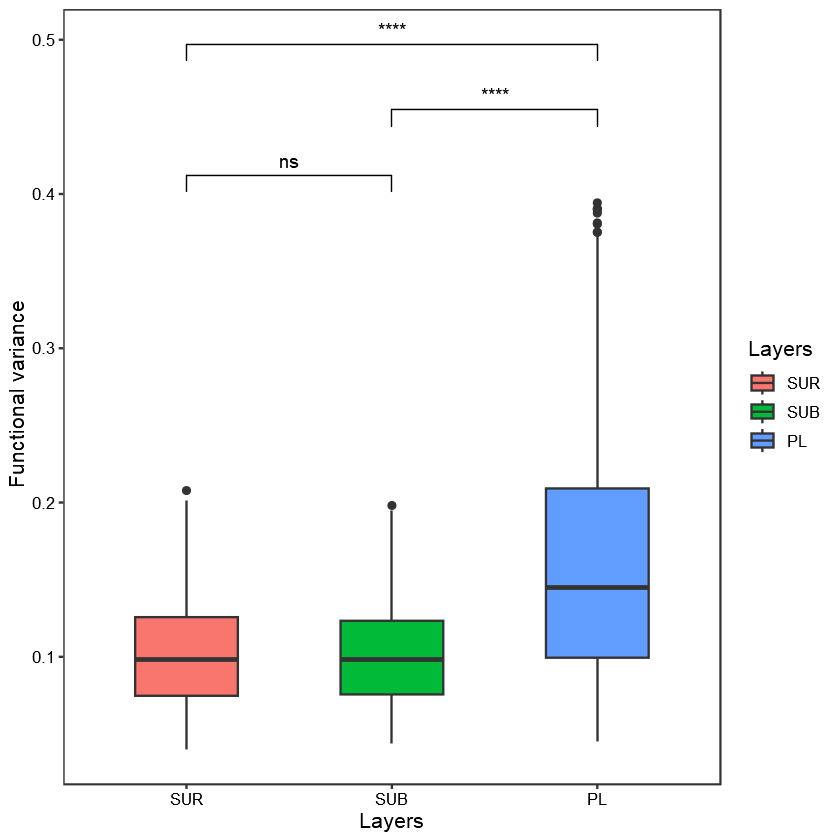

In [5]:
library(ggpubr)
my_comparisons <- list( c("SUR", "SUB"), c("SUB", "PL"), c("SUR", "PL") )
beta_fun_plot <- sapply(unique(metadata$Layer), function(x) usedist::dist_subset(fun_dist, grep(x, metadata$sample_id, value = T))) %>%
  data.frame() %>% gather("Layers", "distance") %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Layers, y = distance)) + 
  geom_boxplot(width = 0.5, aes(fill = Layers))+
  stat_compare_means(comparisons = my_comparisons,  paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols)+
  labs(x = 'Layers', y = 'Functional variance', fill='Layers') +
  theme_bw() +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        panel.grid = element_blank())
print(beta_fun_plot)
# ggsave(file.path(save.dir, "./figs/beta/fun_variance.pdf"),
#        beta_fun_plot, width = 89, height = 89, units = "mm")

## Bin analysis

### set work directory

In [6]:
setwd('e:/permafrost')
wd_fun <- file.path(getwd(),"data/metagenome")
save.dir <- file.path(getwd(),"result")

### loading packages

In [32]:
ipak <- function(pkg){
  new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
  if (length(new.pkg)) 
    install.packages(new.pkg, dependencies = TRUE)
  sapply(pkg, require, character.only = TRUE)
}
pkgs <- c('phyloseq', 'picante', 'microbiome', 'readxl', 'tidyverse',
          'ggpubr', 'ggplot2')
suppressWarnings(ipak(pkgs))

phyloseq    picante microbiome     readxl  tidyverse     ggpubr    ggplot2 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

### reading input files

In [8]:
# tree.file <- file.path(wd_fun, 'binning_70/result/gtdb_tree/bacteria/tax.unrooted.tree')
abundance_tab.file <- file.path(wd_fun, "binning_70/result/bin_abundance_table.tab")
tax.file <- file.path(wd_fun, "binning_70/result/tax.txt")
# bin_fun_file <- file.path(wd_fun, "metabolic/METABOLIC_70/metabolic_heatmap.csv")
metabolic_output_file <- file.path(wd_fun, "/metabolic/METABOLIC_70_layer/METABOLIC_70_all/metabolic.csv")
abundance_tab <- read_delim(abundance_tab.file, col_names = T)
colnames(abundance_tab)[1] <- 'ID'
tax_tab <- read_delim(tax.file, col_names = T)
metabolic_tab <- read.csv(metabolic_output_file) %>%
  select(c('Category', 'Function', grep('Function.presence', colnames(.))))

Rows: 250 Columns: 67
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr  (1): Genomic bins
dbl (66): SUB_2, SUB_3, SUB_1, SUB_6, SUB_7, SUB_4, SUB_5, SUR_21, SUR_20, S...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 250 Columns: 8
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (8): ID, Domain, Phylum, Class, Order, Family, Genus, Species

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


### count the number of MAGs of each Class

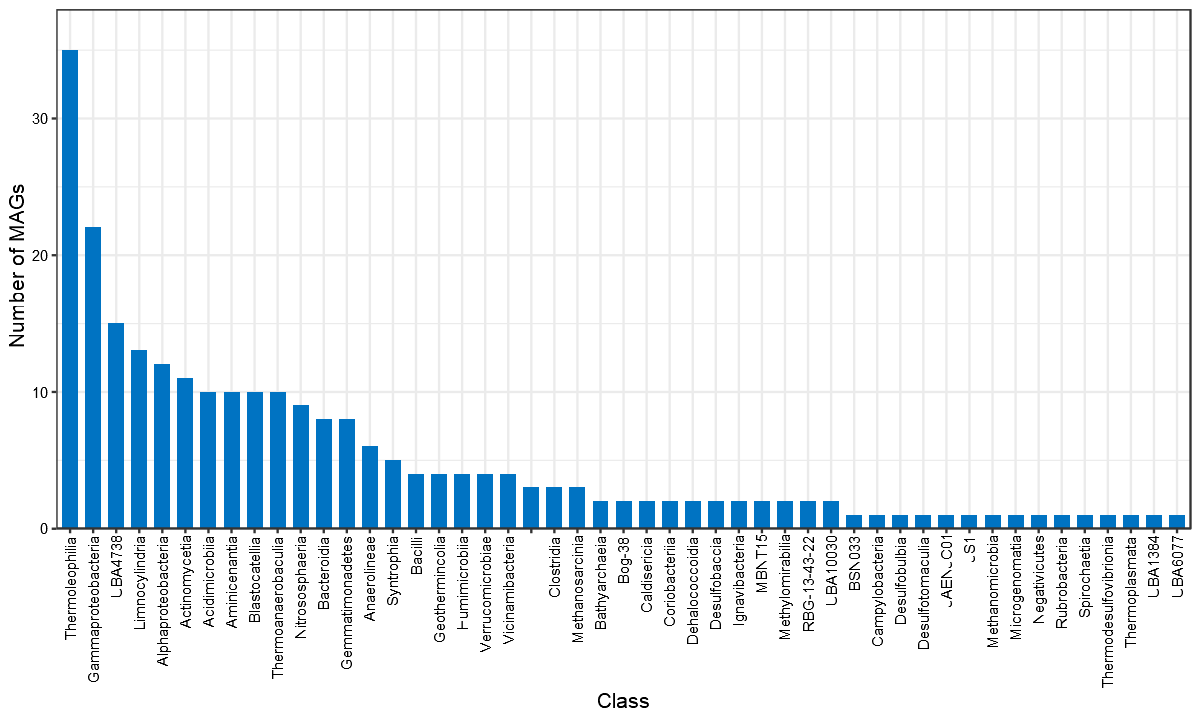

In [9]:
options(repr.plot.width = 10, repr.plot.height = 6)
tax_tab %>% select(c("Class")) %>%
  mutate(number = c(rep(1, nrow(tax_tab)))) %>%
  group_by(Class) %>%
  summarise(across(everything(), sum)) %>%
  arrange(desc(number)) %>%
  mutate(Class = gsub("c__", "", Class)) %>%
  mutate(Class = factor(Class, levels = Class)) %>%
  ggplot(aes(x = Class, y = number)) +
  geom_bar(stat = "identity", fill = "#0073c2", width = 0.65) +
  scale_y_continuous(limits = c(0, 38), expand = c(0, 0)) +
  labs(x = "Class", y = "Number of MAGs") +
  theme_bw() +
  theme(axis.title = element_text(color = "black", size = 12),
        axis.text.x = element_text(colour = "black", angle = 90, vjust = 0.5, hjust=1),
        axis.text.y = element_text(colour = "black"))

### Write the abundance table for itol annotation

In [10]:
dat2 <- abundance_tab %>% 
  mutate(SUR = rowMeans(select(., grep('SUR', colnames(abundance_tab), value = T)))) %>%
  mutate(SUB = rowMeans(select(., grep('SUB', colnames(abundance_tab), value = T)))) %>%
  mutate(PL = rowMeans(select(., grep('PL', colnames(abundance_tab), value = T)))) %>%
  select(c(ID, SUR, SUB, PL)) %>%
  pivot_longer(cols = -c(ID), names_to = "Layers", values_to = 'rel_abun') %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL')))
dat2[1:5, 1:3]
# write the table for itol annotation
# write.csv(dat2, "E:/permafrost/data/metagenome/metabolic/METABOLIC_70_layer/METABOLIC_70_all/itol_DIY_manual/abundance_annotation.csv")

ID,Layers,rel_abun
<chr>,<fct>,<dbl>
s_PL_2_7,SUR,0.04101859
s_PL_2_7,SUB,0.13768484
s_PL_2_7,PL,2.42596330
s_PL_19_5,SUR,0.75452523
s_PL_19_5,SUB,1.06871689


### Metabolic functional MAGs

In [11]:
C_N_metapathway <- c("Amylolytic enzymes", "Cellulose degrading", "Endohemicellulases",
                     "Hemicullulose debranching", "Chitin degrading", 
                     "Phenol => Benzoyl-CoA", "acyl-CoA dehydrogenase",
                     "Other oligosaccharide degrading",
                     "Acetogenesis", "Lactate utilization", "Pyruvate oxidation",  
                     "Pyruvate <=> acetyl-CoA + formate", "Alcohol utilization",
                     "Acetate to acetyl-CoA", "Methane production",
                     "Methane oxidation - Partculate methane monooxygenase",
                     "Methane oxidation - Soluble methane monoxygenase", 
                     "Ammonia oxidation", "Nitrate reduction", "Nitric oxide reduction",
                     "Nitrite oxidation", "Nitrite reduction to ammonia", "Nitrite reduction",
                     "Nitrous oxide reduction", "N2 fixation")

other_metapathway <- c("Sulfate reduction", "Sulfide oxidation", "Sulfite reduction",
                       "Sulfur oxidation", "Sulfur reduction", "Thiosulfate disproportionation", 
                       "Thiosulfate oxidation", "Iron oxidation", "Iron reduction",
                       "Arsenite oxidation", "Arsenate reduction", "Selenate reduction", 
                       "FeFe hydrogenase", "Ni-Fe Hydrogenase")
dat3 <- metabolic_tab %>% 
  filter(Function %in% c(C_N_metapathway, other_metapathway)) %>% 
  mutate(across(starts_with("s_"), ~ifelse(. == "Present", 1, 0))) %>%
  group_by(Category, Function) %>% 
  summarise(across(everything(), sum)) %>%
  filter(rowSums(across(where(is.numeric)))!=0) %>% 
  pivot_longer(cols = -c(Category, Function), names_to = "ID", values_to = 'presence_or_absent') %>%
  mutate(ID = gsub(".Function.presence", "", ID))
dat3[1:5, 1:4]
# write the table for itol annotation
# write.csv(dat3, "E:/permafrost/data/metagenome/metabolic/METABOLIC_70_layer/METABOLIC_70_all/itol_DIY_manual/annotation.csv")

`summarise()` has grouped output by 'Category'. You can override using the `.groups` argument.


Category,Function,ID,presence_or_absent
<chr>,<chr>,<chr>,<dbl>
Aromatics degradation,Phenol => Benzoyl-CoA,s_PL_10_1,0
Aromatics degradation,Phenol => Benzoyl-CoA,s_PL_10_11,0
Aromatics degradation,Phenol => Benzoyl-CoA,s_PL_10_12,1
Aromatics degradation,Phenol => Benzoyl-CoA,s_PL_10_16,0
Aromatics degradation,Phenol => Benzoyl-CoA,s_PL_10_19,0


### Count the number of MAGs of each metabolic parhway (Carbon & Nitrigen and others)

`summarise()` has grouped output by 'Category'. You can override using the `.groups` argument.


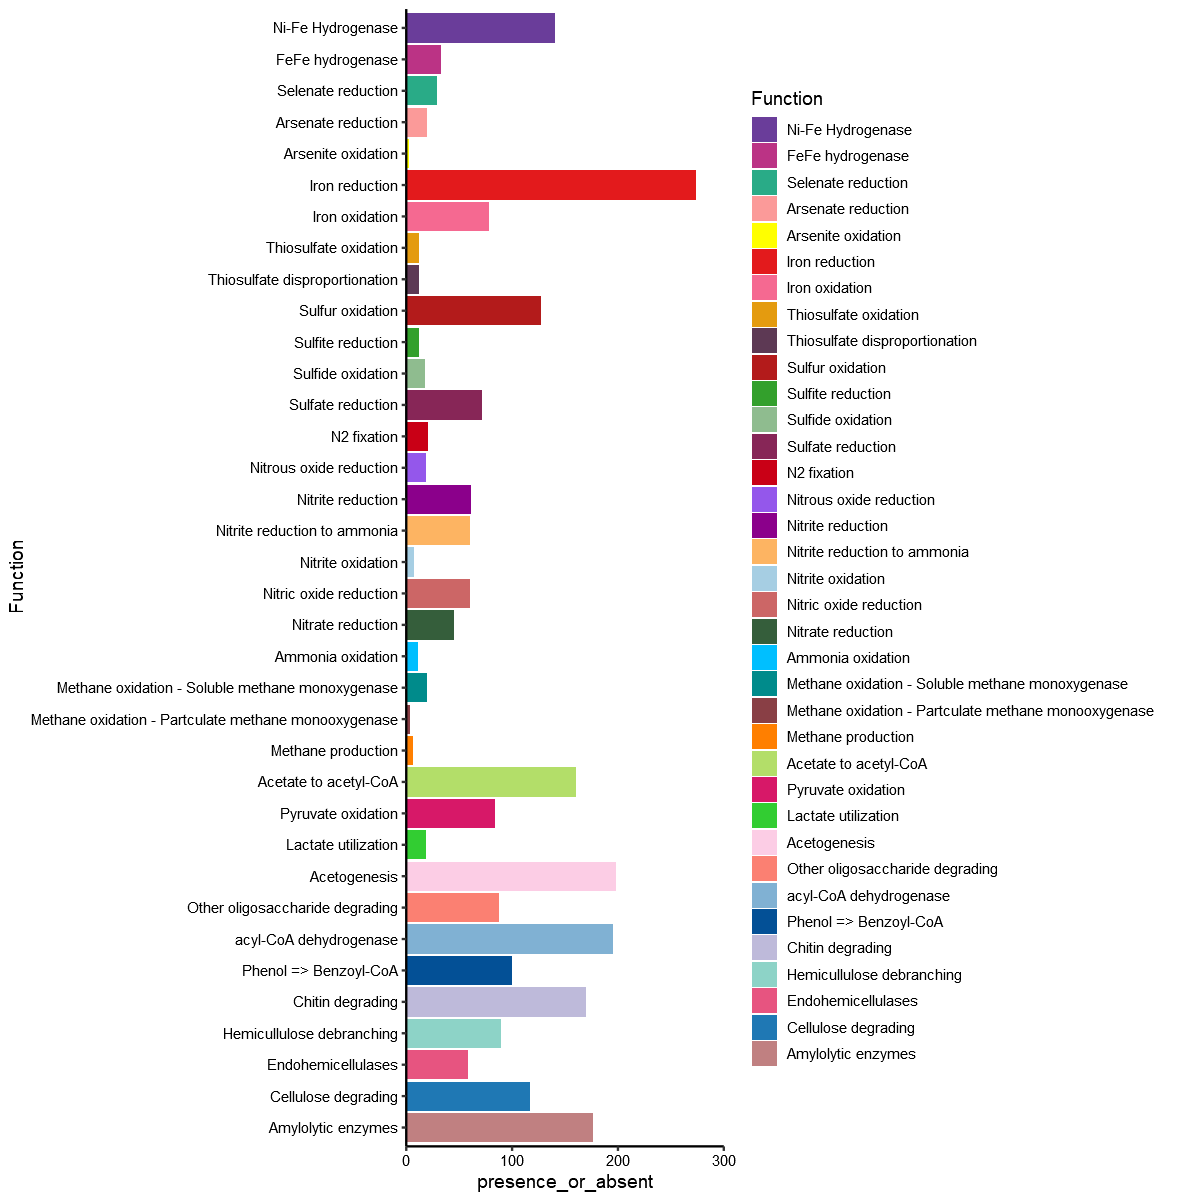

In [12]:
my_colors <- c("#e4d00a", "#FB8072", "#FDB462", "#80B1D3", "#BEBADA", "#B3DE69", "#FCCDE5", "#A6CEE3",
               "#8DD3C7", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#893f45", "#FF7F00", "#1F78B4",
               "#6A3D9A", "#b31b1b", "#5d3954", "#008b8b", "#8b008b", "#e75480", "#872657", "#8fbc8f",
               "#00bfff", "#d71868", "#ffff00", "#c08081", "#cc6666", "#e49b0f", "#c90016", "#355e3b",
               "#29ab87", "#9457eb", "#f56991", "#32cd32", "#035096", "#bb3385")
               
set.seed(1234)  # Set seed
my_colors <- sample(my_colors) # Sample vector            

values = c("#6A3D9A", "#FCCDE5", "#1F78B4", "#A6CEE3", "#B3DE69", "#E69F00", "#56B4E9", "#009E73",
           "#F0E442", "#0072B2", "#D55E00", "#FB9A99", "#E31A1C", "#FDBF6F", "#8DD3C7", "#FFFFB3", 
           "#BEBADA", "#FB8072", "#B2DF8A", "#33A02C", "#FF7F00", "#000000")

values = c("#FFFFB3", "#FB8072", "#FDB462", "#80B1D3", "#BEBADA", "#B3DE69", "#FCCDE5", "#A6CEE3",
           "#8DD3C7", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#1F78B4",
           "#6A3D9A", "#FCCDE5", "#1F78B4", "#A6CEE3", "#B3DE69", "#E69F00", "#56B4E9", "#009E73")
options(repr.plot.width = 10, repr.plot.height = 10)
dat3 %>% select(c(1, 2, 4)) %>%
  group_by(Category, Function) %>% 
  summarise(across(everything(), sum)) %>%
  filter(Function %in% c(C_N_metapathway, other_metapathway)) %>% 
  mutate(Function = factor(Function, levels = c(C_N_metapathway, other_metapathway))) %>%
  ggplot(aes(x = Function, y = presence_or_absent, fill = Function)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = my_colors) +
  scale_y_continuous(limits = c(0, 300), expand = c(0, 0)) +
  theme_classic() +
  theme(axis.text = element_text(colour = 'black'),
        legend.key.size = unit(1.1, "line")) +
  guides(fill = guide_legend(ncol = 1, reverse = TRUE)) +
  coord_flip()

## Metabolic difference among different layers

### Set work directory

In [13]:
sankey.plots.folder <- file.path(wd_fun, "metabolic/results/sankey") # Name of new output folder
if (!dir.exists(sankey.plots.folder)) {
  dir.create(sankey.plots.folder)
}

### Input fiels

In [57]:
sur_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_sur/METABOLIC_Figures_Input/Metabolic_Sankey_diagram_input.txt")
sub_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_sub/METABOLIC_Figures_Input/Metabolic_Sankey_diagram_input.txt")
pl_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_pl/METABOLIC_Figures_Input/Metabolic_Sankey_diagram_input.txt")

### Load packages

In [45]:
pkgs <- c('ggthemes', 'networkD3', 'data.table')
suppressWarnings(ipak(pkgs))

ggthemes  networkD3 data.table 
      TRUE       TRUE       TRUE

###  Generate a snakey plot with reactions as node, and edges are MAGs, and are colored by taxonomic group.

In [46]:
# Load the energy flow diagram input ---------------------------
table_sur <- read.table(sur_input_table, header = F, sep = "\t")
colnames(table_sur) <- c("Taxa", "Reaction", "Freq")
table_sub <- read.table(sub_input_table, header = F, sep = "\t")
colnames(table_sub) <- c("Taxa", "Reaction", "Freq")
table_pl <- read.table(pl_input_table, header = F, sep = "\t")
colnames(table_pl) <- c("Taxa", "Reaction", "Freq")

In [47]:
# Rename the categories ---------------------------
table_sur$Category <- ifelse(grepl("C-S", table_sur$Reaction), "Carbon", 
                               ifelse(grepl("N-S", table_sur$Reaction), "Nitrogen",
                                      ifelse(grepl("S-S", table_sur$Reaction), "Sulfur",
                                             ifelse(grepl("O-S", table_sur$Reaction), "Others",""))))
table_sur$Category <- as.factor(table_sur$Category)

table_sub$Category <- ifelse(grepl("C-S", table_sub$Reaction), "Carbon", 
                               ifelse(grepl("N-S", table_sub$Reaction), "Nitrogen",
                                      ifelse(grepl("S-S", table_sub$Reaction), "Sulfur",
                                             ifelse(grepl("O-S", table_sub$Reaction), "Others",""))))
table_sub$Category <- as.factor(table_sub$Category)

table_pl$Category <- ifelse(grepl("C-S", table_pl$Reaction), "Carbon", 
                               ifelse(grepl("N-S", table_pl$Reaction), "Nitrogen",
                                      ifelse(grepl("S-S", table_pl$Reaction), "Sulfur",
                                             ifelse(grepl("O-S", table_pl$Reaction), "Others",""))))
table_pl$Category <- as.factor(table_pl$Category)

In [50]:
# reformate the data
table_all <- rbind(cbind(Layer = rep("SUR", nrow(table_sur)), table_sur),
                   cbind(Layer = rep("SUB", nrow(table_sub)), table_sub),
                   cbind(Layer = rep("PL", nrow(table_pl)), table_pl)) %>%
  mutate(Layer = factor(Layer, levels = c("SUR", "SUB", "PL")))

taxa_names <- table_all %>% select(Taxa, Freq) %>%
  group_by(Taxa) %>%
  summarise(sum = sum(Freq)) %>%
  arrange(desc(sum)) %>%
  pull(Taxa)
reaction_orders <- c(sort(grep('C-', unique(table_all$Reaction), value = T), decreasing = F),
                     sort(grep('N-', unique(table_all$Reaction), value = T), decreasing = F),
                     sort(grep('S-S', unique(table_all$Reaction), value = T), decreasing = F),
                     sort(grep('O-', unique(table_all$Reaction), value = T), decreasing = F))

table_all <- table_all %>%
  mutate(Taxa = factor(Taxa, levels = taxa_names)) %>%
  mutate(Category = factor(Category, levels = c('Carbon', 'Nitrogen', 
                                                'Sulfur', 'Others'))) %>%
  mutate(Reaction = factor(Reaction, levels = reaction_orders))

sankey <- data.table::rbindlist(list(table_all[c("Layer", "Taxa", "Freq")],
                         table_all[c("Taxa", "Reaction", "Freq")]))
names(sankey) <- c('source', 'target', 'value')
sankey[1:5, ]

Column 2 ['Reaction'] of item 2 is missing in item 1. Use fill=TRUE to fill with NA (NULL for list columns), or use.names=FALSE to ignore column names. use.names='check' (default from v1.12.2) emits this message and proceeds as if use.names=FALSE for  backwards compatibility. See news item 5 in v1.12.2 for options to control this message.



source,target,value
<fct>,<fct>,<dbl>
SUR,Desulfobacterota,0.05246876
SUR,Desulfobacterota,0.05246876
SUR,Desulfobacterota,0.05246876
SUR,Desulfobacterota,0.05246876
SUR,Desulfobacterota,0.05246876


In [51]:
# Make a connection data frame
links <- sankey 
# From these flows we need to create a node data frame: it lists every entities involved in the flow
nodes <- data.frame(
  name = c(as.character(links$source), as.character(links$target)) %>% 
    unique()
)
nodes <- data.frame(
  name = c("SUR", "SUB", "PL", taxa_names,
           sort(grep('C-', unique(table_all$Reaction), value = T), decreasing = F),
           sort(grep('N-', unique(table_all$Reaction), value = T), decreasing = F),
           sort(grep('S-S', unique(table_all$Reaction), value = T), decreasing = F),
           sort(grep('O-', unique(table_all$Reaction), value = T), decreasing = F))
)
# With networkD3, connection must be provided using id, not using real name like in the links dataframe.. So we need to reformat it.
links$IDsource <- match(links$source, nodes$name)-1 
links$IDtarget <- match(links$target, nodes$name)-1

In [52]:
# Set color of connections
# Add a 'group' column to each connection:
ass_link_col_fun <- function(df) {
  if (df["source"] == taxa_names[1] | df["target"] == taxa_names[1]) {
    group = 'a'
  } else if (df["source"] == taxa_names[2] | df["target"] == taxa_names[2]) {
    group = 'b'
  } else if (df["source"] == taxa_names[3] | df["target"] == taxa_names[3]) {
    group = 'c'
  } else if (df["source"] == taxa_names[4] | df["target"] == taxa_names[4]) {
    group = 'd'
  } else if (df["source"] == taxa_names[5] | df["target"] == taxa_names[5]) {
    group = 'e'
  } else if (df["source"] == taxa_names[6] | df["target"] == taxa_names[6]) {
    group = 'f'
  } else if (df["source"] == taxa_names[7] | df["target"] == taxa_names[7]) {
    group = 'g'
  } else if (df["source"] == taxa_names[8] | df["target"] == taxa_names[8]) {
    group = 'h'
  } else if (df["source"] == taxa_names[9] | df["target"] == taxa_names[9]) {
    group = 'i'
  } else if (df["source"] == taxa_names[10] | df["target"] == taxa_names[10]) {
    group = 'j'
  } else if (df["source"] == taxa_names[11] | df["target"] == taxa_names[11]) {
    group = 'k'
  } else if (df["source"] == taxa_names[12] | df["target"] == taxa_names[12]) {
    group = 'l'
  } else if (df["source"] == taxa_names[13] | df["target"] == taxa_names[13]) {
    group = 'm'
  } else if (df["source"] == taxa_names[14] | df["target"] == taxa_names[14]) {
    group = 'n'
  } else if (df["source"] == taxa_names[15] | df["target"] == taxa_names[15]) {
    group = 'o'
  } else if (df["source"] == taxa_names[16] | df["target"] == taxa_names[16]) {
    group = 'p'
  } else if (df["source"] == taxa_names[17] | df["target"] == taxa_names[17]) {
    group = 'q'
  } else if (df["source"] == taxa_names[18] | df["target"] == taxa_names[18]) {
    group = 'r'
  } else if (df["source"] == taxa_names[19] | df["target"] == taxa_names[19]) {
    group = 's'
  } else if (df["source"] == taxa_names[20] | df["target"] == taxa_names[20]) {
    group = 't'
  } else if (df["source"] == taxa_names[21] | df["target"] == taxa_names[21]) {
    group = 'u'
  } else if (df["source"] == taxa_names[21] | df["target"] == taxa_names[21]) {
    group = 'u'
  }
  return(group)
}
links$group <- apply(links, 1, ass_link_col_fun)

# Add a 'group' column to each node. Here I decide to put all of them in the same group to make them grey
nodes$group <- as.factor(c("my_unique_group"))
links[1:5, ]
nodes[1:5, ]

source,target,value,IDsource,IDtarget,group
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>
SUR,Desulfobacterota,0.05246876,0,8,f
SUR,Desulfobacterota,0.05246876,0,8,f
SUR,Desulfobacterota,0.05246876,0,8,f
SUR,Desulfobacterota,0.05246876,0,8,f
SUR,Desulfobacterota,0.05246876,0,8,f


,name,group
,<chr>,<fct>
1,SUR,my_unique_group
2,SUB,my_unique_group
3,PL,my_unique_group
4,Actinobacteriota,my_unique_group
5,Alphaproteobacteria,my_unique_group


In [21]:
# Give a color for each group
my_color <- 'd3.scaleOrdinal() .domain(["a", "b", "c", "d", "e", "f", 
"g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", 
"Carbon", "Nitrogen", "Sulfur", "Others", "my_unique_group"]) .range(["#FF7F00", "#B3DE69", 
"#1F78B4", "#FB8072", "#FDB462", "#80B1D3", "#BEBADA", "#c988d1", "#FCCDE5", "#A6CEE3",
"#8DD3C7", "#B2DF8A", "#33A02C", "#FB9A99", "#FFFFB3", "#FDBF6F", "#E31A1C", "#d5416a", 
"#76c2d7", "#d87a71","#6a75d5", "#76c2d7", "#d87a71", "#6a75d5", "#836834", 
"grey"])'

# Make the Network. I call my colour scale with the colourScale argument
sankeyNetwork(Links = links, Nodes = nodes, Source = "IDsource", Target = "IDtarget", 
                   Value = "value", NodeID = "name", colourScale = my_color, 
                   LinkGroup="group", iterations = 0, fontFamily = 'Arial', fontSize = 10, 
                   nodeWidth = 20, nodePadding = 10, height = 700, width = 750,
                   sinksRight = F)
# save the widget
# library(htmlwidgets)
# saveWidget(p, file = paste0(sankey.plots.folder, "/sankey_plot.html"))
# library(webshot)
# install phantom:
# webshot::install_phantomjs()
# Make a webshot in pdf : high quality but can not choose printed zone
# webshot(paste0(sankey.plots.folder, "/sankey_plot.html"), 
#         paste0(sankey.plots.folder, "/sankey_plot11.pdf"), delay = 0.2)


HTML widgets cannot be represented in plain text (need html)

## Metabolic interaction with network

### read input files

In [58]:
sur_net_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_sur/METABOLIC_Figures_Input/functional_network_input.txt")
sub_net_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_sub/METABOLIC_Figures_Input/functional_network_input.txt")
pl_net_input_table <- file.path(wd_fun, "metabolic/METABOLIC_70_layer/METABOLIC_70_pl/METABOLIC_Figures_Input/functional_network_input.txt")

network.plots.folder <- file.path(wd_fun, "metabolic/results/network")
table_sur <- read.csv(sur_net_input_table, header=T, sep="\t")
table_sub <- read.csv(sub_net_input_table, header=T, sep="\t")
table_pl <- read.csv(pl_net_input_table, header=T, sep="\t")


###  Generate a network plot with reactions as node, and edges are MAGs, and are colored by taxonomic group.

In [61]:
pkgs <- c('ggraph', 'igraph', 'tidyverse', 'tidygraph', 'cowplot')
suppressWarnings(ipak(pkgs))

ggraph    igraph tidyverse tidygraph   cowplot 
     TRUE      TRUE      TRUE      TRUE      TRUE

In [60]:
my_graph_sur <- table_sur[, c(2,3,4,5)] %>% 
  graph_from_data_frame()
my_graph_sub <- table_sub[, c(2,3,4,5)] %>% 
  graph_from_data_frame()
my_graph_pl <- table_pl[, c(2,3,4,5)] %>% 
  graph_from_data_frame()

deg_sur <- degree(my_graph_sur, mode="all")
deg_sub <- degree(my_graph_sub, mode="all")
deg_pl <- degree(my_graph_pl, mode="all")

# color
sur_color <- c("#d64e9e", "#6cd54c", "#dd49d1", "#432d7c", "#c6d179", "#8f379a", "#c988d1")
sub_color <- c("#d64e9e", "#6cd54c", "#dd49d1", "#a152dd", "#5139c2", "#ceaa3b", "#432d7c",
               "#c6d179", "#8f379a", "#70d68c", "#d9432f", "#6ad5be", "#d5416a",
               "#6a75d5", "#c988d1", "#598939")
pl_color <- c("#d64e9e", "#6cd54c", "#dd49d1", "#c8dd41", "#a152dd", "#4d4040",
              "#ceaa3b", "#7a3260", "#432d7c", "#c6d179", "#8f379a", "#70d68c",
              "#d9432f", "#6ad5be", "#76c2d7", "#d87a71", "#6a75d5", "#836834",
              "#c988d1", "#598939")
# this generates the whole community plot
community.plot_sur <- table_sur[, c(2,3,4,5)] %>% 
  graph_from_data_frame() %>% 
  ggraph(layout = "linear", circular = TRUE) +
  geom_edge_arc(alpha = .25, 
                aes(width = Coverage.value.average., color=as.factor(Taxonomic.Group))) +
  scale_edge_colour_manual(values = sur_color) +
  geom_node_point(aes(size = 0.02*deg_sur), color = "black", alpha = 0.75) +
  geom_node_text(aes(label = name),  color="black", repel = TRUE)+
  #theme_graph()+
  labs(title = 'Metabolic connections within dataset', 
       subtitle = 'No scaling')

community.plot_sub <- table_sub[, c(2,3,4,5)] %>% 
  graph_from_data_frame() %>% 
  ggraph(layout = "linear", circular = TRUE) +
  geom_edge_arc(alpha = .25, 
                aes(width = Coverage.value.average., color=as.factor(Taxonomic.Group))) +
  scale_edge_colour_manual(values = sub_color) +
  geom_node_point(aes(size = 0.02*deg_sub), color = "black", alpha = 0.75) +
  geom_node_text(aes(label = name),  color="black", repel = TRUE)+
  #theme_graph()+
  labs(title = 'Metabolic connections within dataset', 
       subtitle = 'No scaling')

community.plot_pl <- table_pl[, c(2,3,4,5)] %>% 
  graph_from_data_frame() %>% 
  ggraph(layout = "linear", circular = TRUE) +
  geom_edge_arc(alpha = .25, 
                aes(width = Coverage.value.average., color=as.factor(Taxonomic.Group))) +
  scale_edge_colour_manual(values = pl_color) +
  geom_node_point(aes(size = 0.02*deg_pl), color = "black", alpha = 0.75) +
  geom_node_text(aes(label = name),  color="black", repel = TRUE)+
  #theme_graph()+
  labs(title = 'Metabolic connections within dataset', 
       subtitle = 'No scaling')

In [24]:
### Grid draw community.plot

Warning message:
"ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


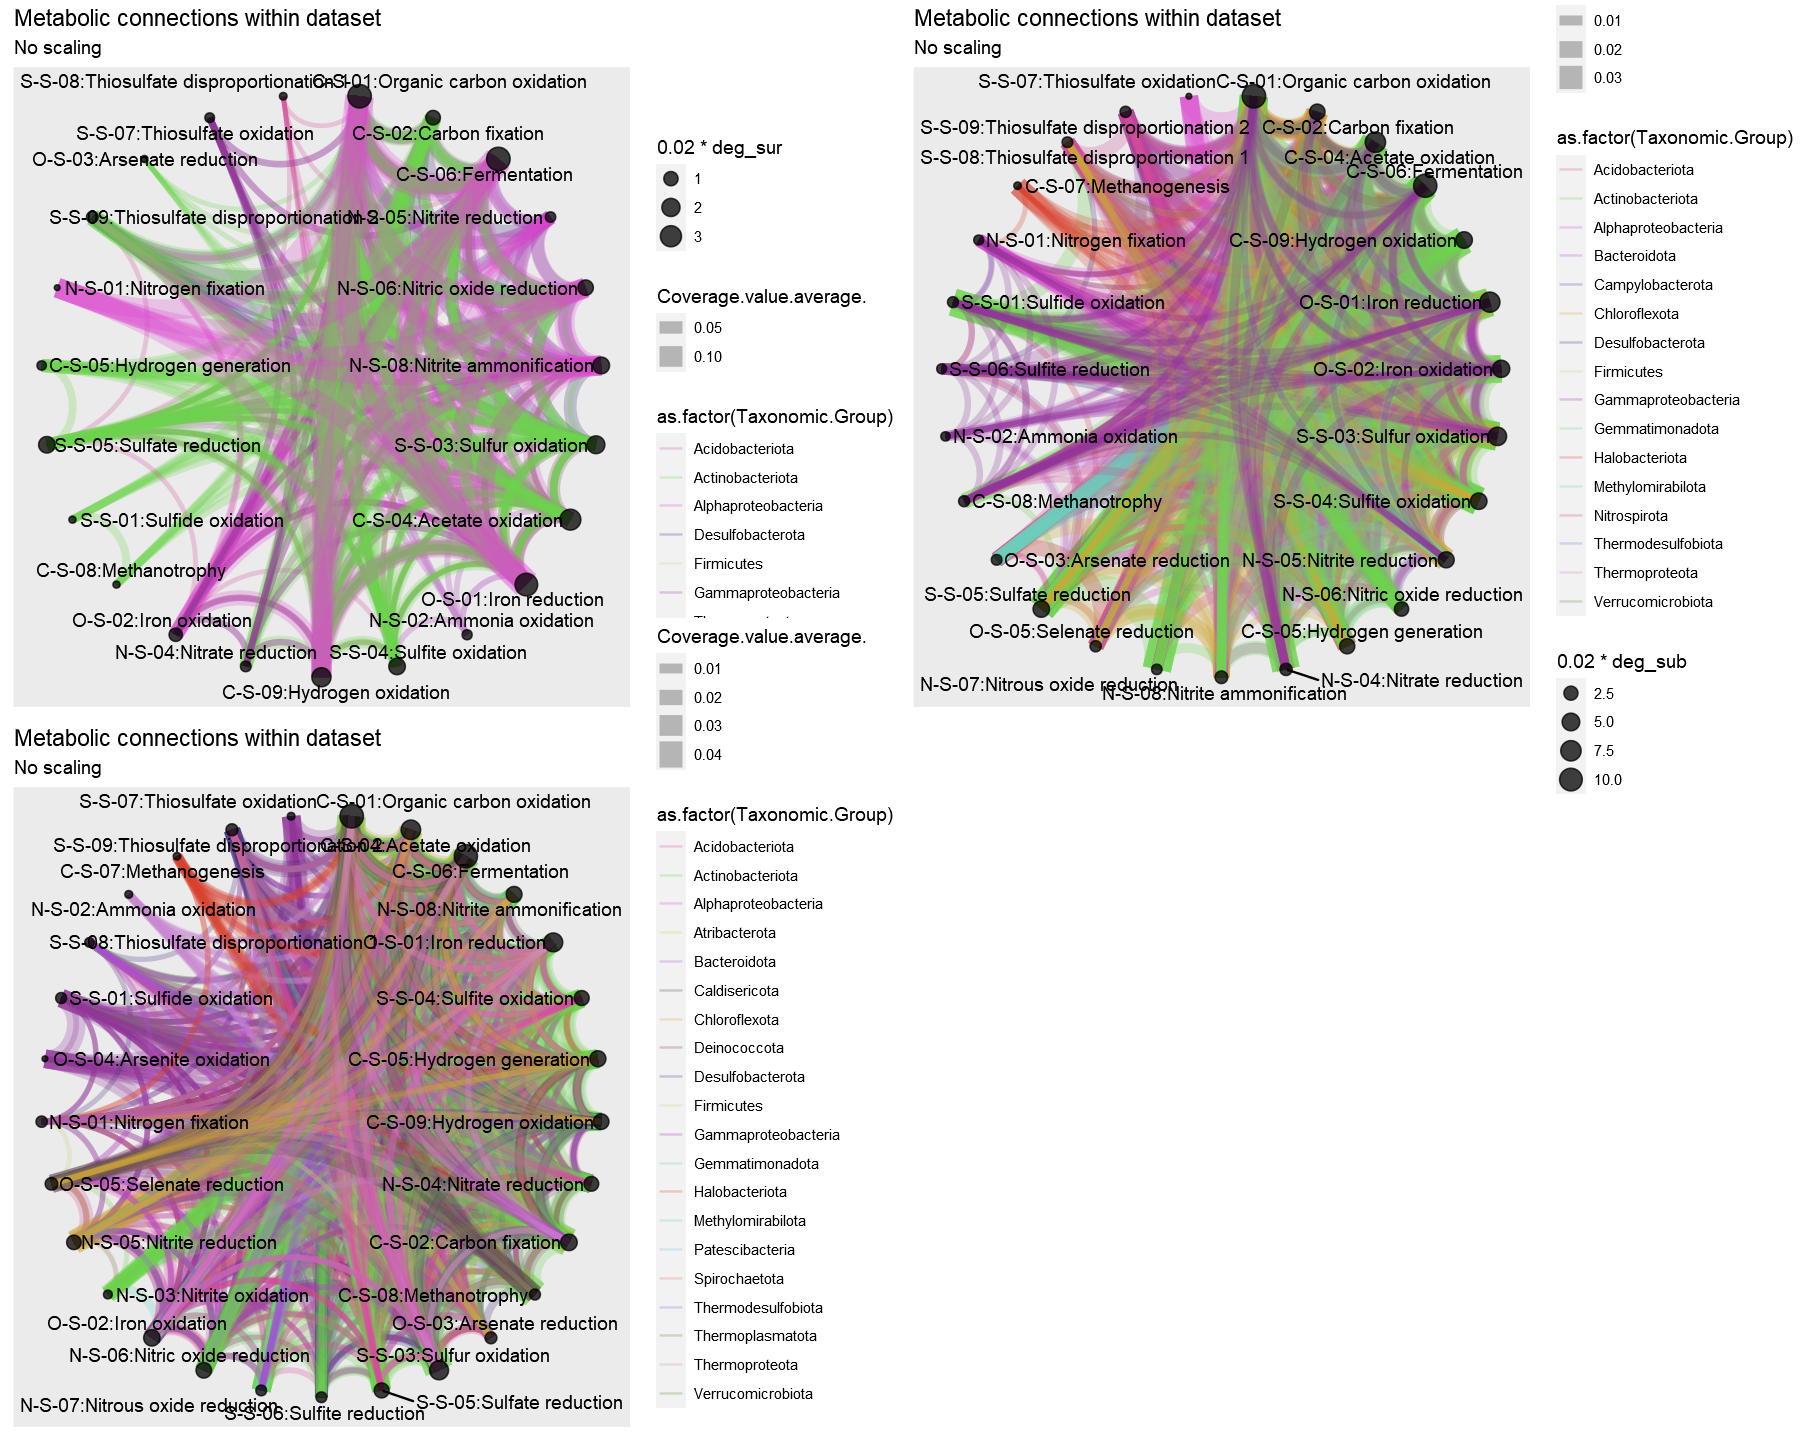

In [62]:
# community.plot
options(repr.plot.width = 15, repr.plot.height = 12)
plot_grid(community.plot_sur, community.plot_sub, community.plot_pl)
# community.plot <- ggdraw() +
#   draw_plot(community.plot_sur, x = 0, y = 0, width = 1/3, height = 1) +
#   draw_plot(community.plot_sub, x = 1/3, y = 0, width = 1/3, height = 1) +
#   draw_plot(community.plot_pl, x = 2/3, y = 0, width = 1/3, height = 1) +
#   draw_plot_label(label = c("A", "B", 'C'), size = 10,
#                   x = c(0, 1/3, 2/3), y = c(1, 1, 1))
# community.plot
# plot.name <- paste0(network.plots.folder, "/SurCommunityPlot.PDF")
# print(plot.name)
# cairo_pdf(filename = plot.name, width = 8, height = 5.5, onefile = TRUE)
# community.plot_sur
# dev.off()

# plot.name <- paste0(network.plots.folder, "/SubCommunityPlot.PDF")
# print(plot.name)
# cairo_pdf(filename = plot.name, width = 8, height = 5.5, onefile = TRUE)
# community.plot_sub
# dev.off()

# plot.name <- paste0(network.plots.folder, "/PlCommunityPlot.PDF")
# print(plot.name)
# cairo_pdf(filename = plot.name, width = 8, height = 5.5, onefile = TRUE)
# community.plot_pl
# dev.off()

### Explore the relationship of bin with carbon flux in permafrost layers

Rows: 22 Columns: 16
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (1): Genomic bins
dbl (15): s_SUB_12_6, s_SUB_18_11, s_SUR_2_3, s_SUR_18_2, s_SUB_15_15, s_SUB...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


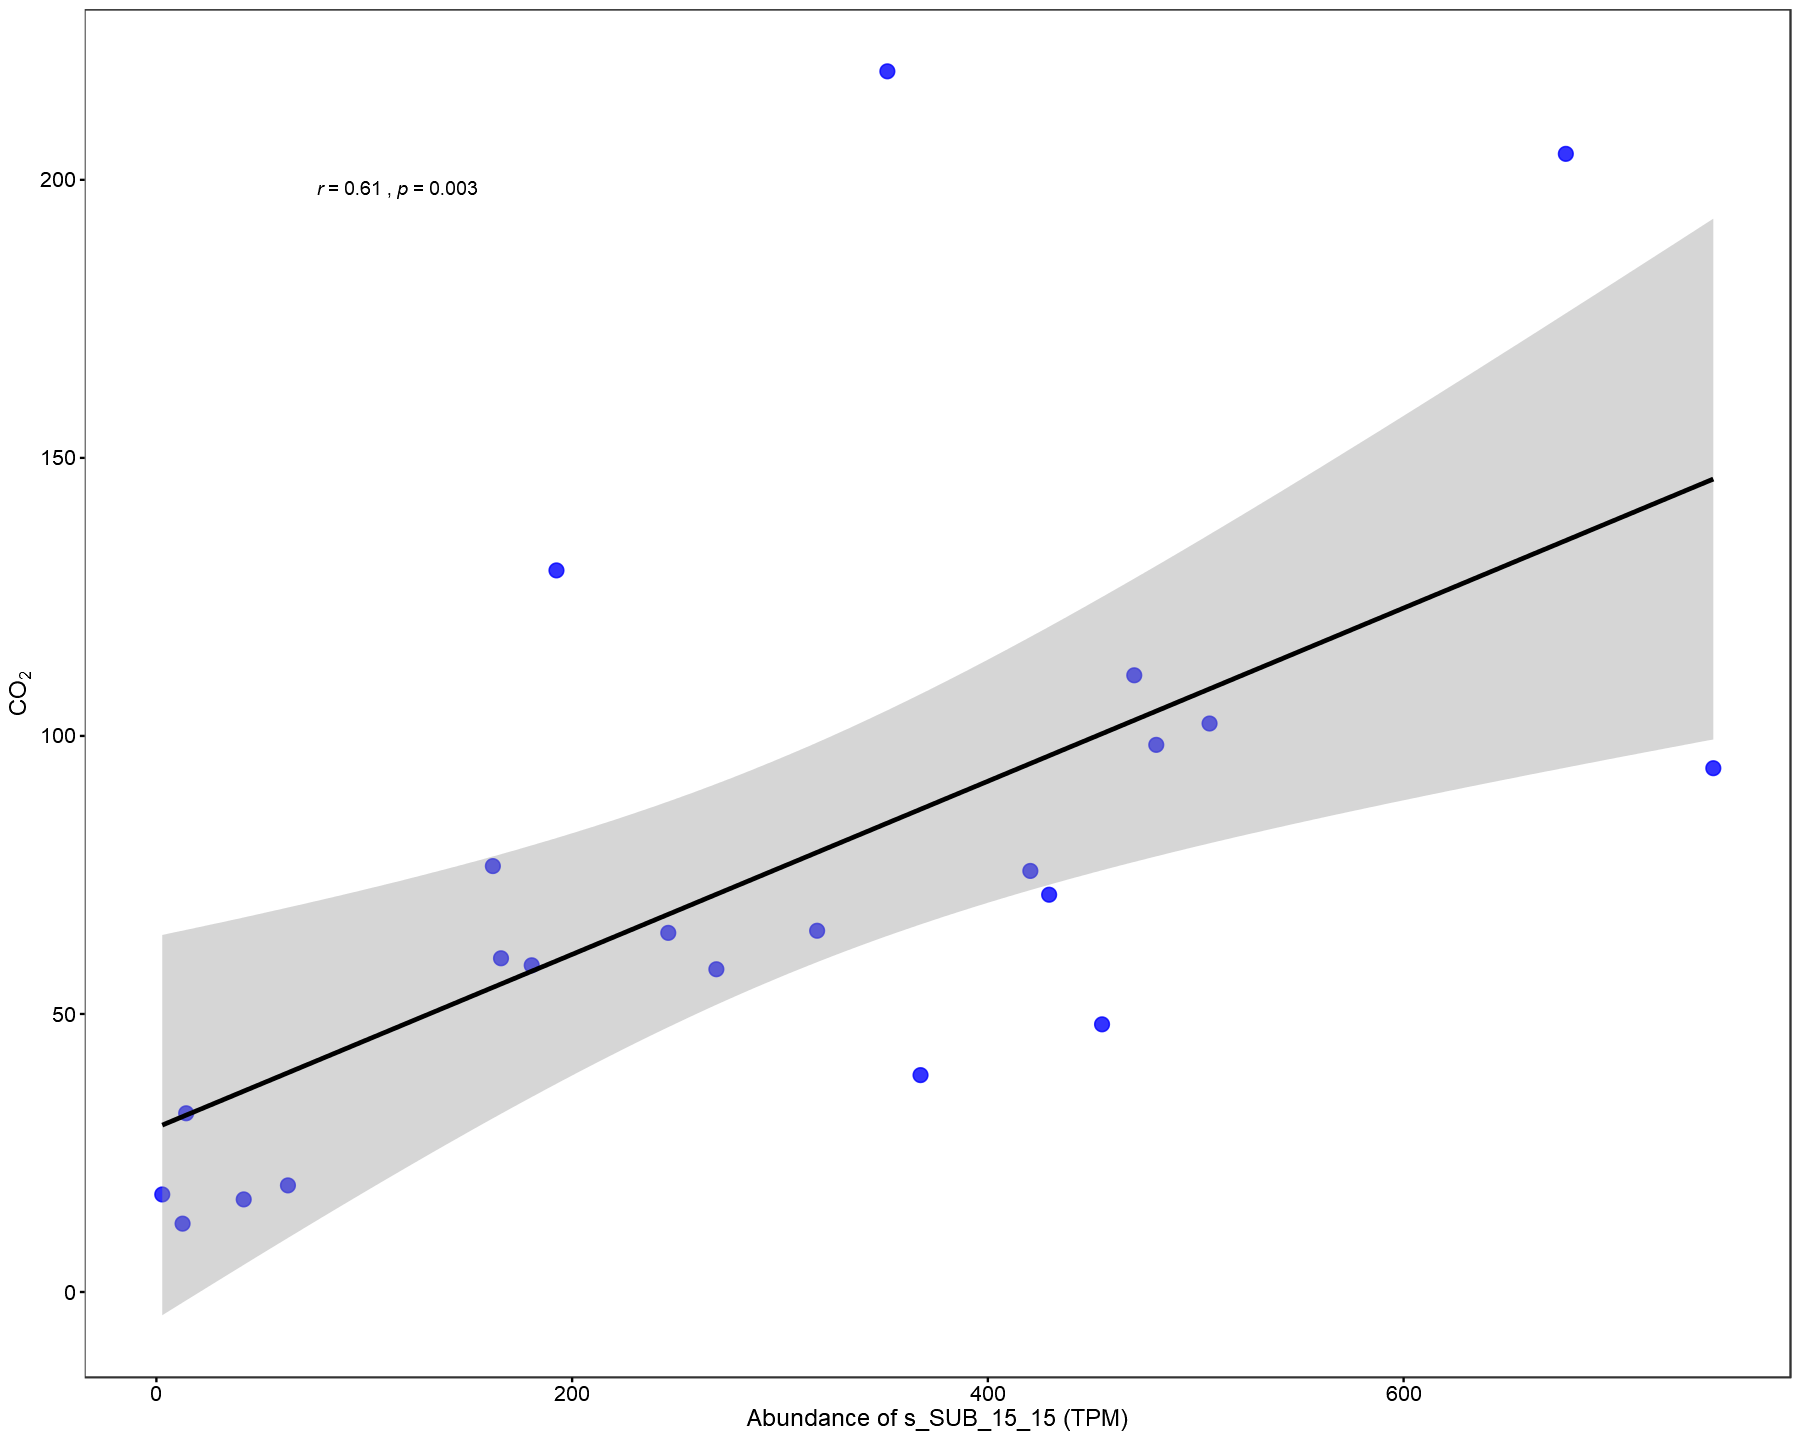

In [31]:
library(ggpmisc)
bin_flux_file = file.path(wd_fun, '/bin_flux.csv')
bin_flux <- read_delim(bin_flux_file, col_names = T)
p <- ggplot(bin_flux, aes(x = s_SUB_15_15, y = Cumulative_5)) +
  geom_point(size=3.5, alpha=0.8, colour= '#0000ff') +
  geom_smooth(method = "lm", formula = y ~ poly(x, 1, raw = TRUE), size = 1, se = T, colour = 'black') +
  ggpubr::stat_cor(aes(s_SUB_15_15, Cumulative_5, label = paste(..r.label.., ..p.label.., sep = "~`,`~")),
                   cor.coef.name = "r", p.accuracy = 0.001, r.accuracy = 0.01,
                   method = "pearson", label.x.npc = 0.1, label.y.npc = 0.9, size = 4) +
  xlab("Abundance of s_SUB_15_15 (TPM)") + ylab(expression(CO[2])) +
  theme_bw() +
  theme(panel.grid=element_blank(), 
        axis.title = element_text(color='black',size=14),
        axis.ticks.length = unit(0.2,"lines"), axis.ticks = element_line(color='black'),
        axis.line = element_blank(), 
        axis.text.y = element_text(colour='black',size=12),
        axis.text.x = element_text(colour='black', size = 12),
        strip.text = element_text(size = 14),
        legend.position='none')
print(p)
# ggsave(file.path(save.dir, "./figs/bin/bin_flux.pdf"),
#        p, width = 110, height = 120, units = "mm")
